# Importing the libraries

For completing this task, the following libraries are utilized. The library used for training the deep learning network is TensorFlow.

In [1]:
# Library for os functionality
import os

# Libraries for manipulating and visualizing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Libraries for training the model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-08-08 12:47:29.996963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 12:47:30.033281: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 12:47:30.033903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 12:47:30.759917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Base parameters for training

The following parameters are selected for the training after fine-tuning.

In [2]:
# Get the currentworking directory
BASE_DIR = os.getcwd()

# Base model used for transfer learning
MODEL_NAME = MobileNetV3Small

# Parameters selected for training
LEARNING_RATE = 0.002
MIN_LEARNING_RATE = 0.0001
BATCH_SZ = 64
SCALE_FACTOR = 1
VAL_TEST_RATIO = 0.2
MAX_EPOCHS = 50

# Data preprocessing

The data is splitted by using the provided CSV file. The test set is 20% of the total data, and the validation set is 20% of the remaining train set.

In [3]:
# Path to the directory containing images
image_directory = os.path.join(BASE_DIR, 'imgs')

# Load the CSV file
csv_file = os.path.join(BASE_DIR, 'car_imgs_4000.csv')
data = pd.read_csv(csv_file)

# Display the first few rows of the dataframe
print(data.head())

# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(data, test_size=VAL_TEST_RATIO, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=VAL_TEST_RATIO, random_state=42)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")

                                   filename  perspective_score_hood  \
0  66ee2d88-f403-4821-a370-8a3d72e200f9.jpg                 0.27352   
1  bf7e237e-f12b-4ffc-8d79-6855cc35ea06.jpg                 0.00000   
2  4c297488-c81f-464d-92bf-1c408333a912.jpg                 0.00000   
3  6c95ad0b-fda6-42a8-a33d-b430073e1dcd.jpg                 0.00000   
4  bd806d94-4c2e-4cd2-8e02-5eaba7c7c63e.jpg                 0.00000   

   perspective_score_backdoor_left  
0                         0.439526  
1                         0.902682  
2                         0.900864  
3                         0.213162  
4                         0.818388  
Training samples: 2560, Validation samples: 640, Test samples: 800


# Data augmentation

Data generator are created to load and augment the images.

In [4]:
# Image dimensions
image_size = (224, 224)

# Create ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=SCALE_FACTOR
)

val_test_datagen = ImageDataGenerator(rescale=SCALE_FACTOR)

# Create generators for training, validation, and test datasets
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=image_directory,
    x_col='filename',
    y_col=['perspective_score_hood', 'perspective_score_backdoor_left'],
    target_size=image_size,
    batch_size=BATCH_SZ,
    class_mode='raw'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    directory=image_directory,
    x_col='filename',
    y_col=['perspective_score_hood', 'perspective_score_backdoor_left'],
    target_size=image_size,
    batch_size=BATCH_SZ,
    class_mode='raw'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    directory=image_directory,
    x_col='filename',
    y_col=['perspective_score_hood', 'perspective_score_backdoor_left'],
    target_size=image_size,
    batch_size=BATCH_SZ,
    class_mode='raw',
    shuffle=False
)

Found 2560 validated image filenames.
Found 640 validated image filenames.
Found 800 validated image filenames.


# Model architecture

MobileNetV3Small is utilized for transfer learning and due to their ability of powering on-device computer vision. All the layers besides the final three layers are frozen. Two custom fully-connected layers and and output layer for this problem are added.

In [5]:
# Load pre-trained MobileNetV3Small model without the top layer
base_model = MODEL_NAME(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)), pooling='avg')

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-3:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = Dense(512, activation='relu')(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error', metrics=['mean_absolute_error'])


# Model training

Model is trained using the above mentioned parameters and architecture.

In [6]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=MIN_LEARNING_RATE)
max_epochs = MAX_EPOCHS

# Train the model
history = model.fit(
    train_generator,
    epochs=max_epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
40/40 [==============================] - 24s 553ms/step - loss: 0.1951 - mean_absolute_error: 0.2981 - val_loss: 0.1653 - val_mean_absolute_error: 0.2729 - lr: 0.0020
Epoch 2/50
40/40 [==============================] - 22s 554ms/step - loss: 0.1078 - mean_absolute_error: 0.2301 - val_loss: 0.0591 - val_mean_absolute_error: 0.1684 - lr: 0.0020
Epoch 3/50
40/40 [==============================] - 23s 577ms/step - loss: 0.0500 - mean_absolute_error: 0.1535 - val_loss: 0.0498 - val_mean_absolute_error: 0.1462 - lr: 0.0020
Epoch 4/50
40/40 [==============================] - 22s 557ms/step - loss: 0.0383 - mean_absolute_error: 0.1267 - val_loss: 0.0447 - val_mean_absolute_error: 0.1309 - lr: 0.0020
Epoch 5/50
40/40 [==============================] - 22s 555ms/step - loss: 0.0326 - mean_absolute_error: 0.1128 - val_loss: 0.0450 - val_mean_absolute_error: 0.1293 - lr: 0.0020
Epoch 6/50
40/40 [==============================] - 22s 548ms/step - loss: 0.0275 - mean_absolute_error: 0.101

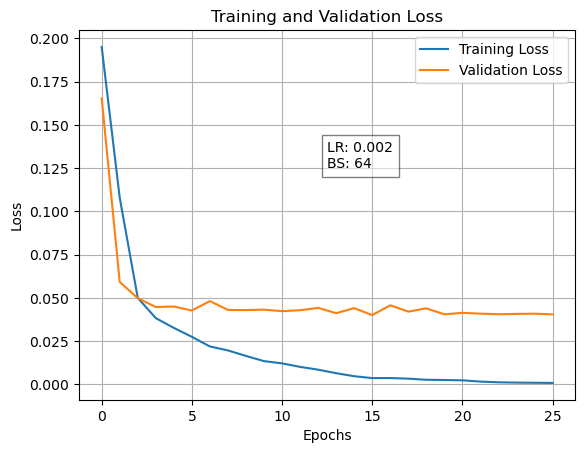

In [7]:
def plot_err_curve():
    """
    Generates error curve comparing training and validation error.
    """
    title_desc = 'Training and Validation Loss'
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title_desc)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.text(x=0.5, y=0.7, s=f'LR: {LEARNING_RATE}\nBS: {BATCH_SZ}',
            transform=plt.gca().transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    plt.show()
    
plot_err_curve()

# Model evaluation

The model is evaluated by calculing the MSE and MAE. The MAE provided an easy intuition of the difference between the actual values and model predictions.

In [8]:
# Evaluate the model on the test dataset
test_loss, test_mse = model.evaluate(test_generator)
print(f"Test MSE: {test_mse}")

# Make predictions on the test dataset
predictions = model.predict(test_generator)

# Compare predictions with actual values
actual = test_df[['perspective_score_hood', 'perspective_score_backdoor_left']].values
# print(f"Predictions: {predictions[:5]}")
# print(f"Actual: {actual[:5]}")

# Calculate the mean absolute error for evaluation
mae = np.mean(np.abs(predictions - actual), axis=0)
print(f"Mean Absolute Error for Hood: {mae[0]}, Backdoor Left: {mae[1]}")

13/13 [==============================] - 5s 403ms/step - loss: 0.0502 - mean_absolute_error: 0.1183
Test MSE: 0.11829618364572525
13/13 [==============================] - 6s 396ms/step
Mean Absolute Error for Hood: 0.055053217736594016, Backdoor Left: 0.18153915620743338


1/1 [==============================] - 1s 588ms/step


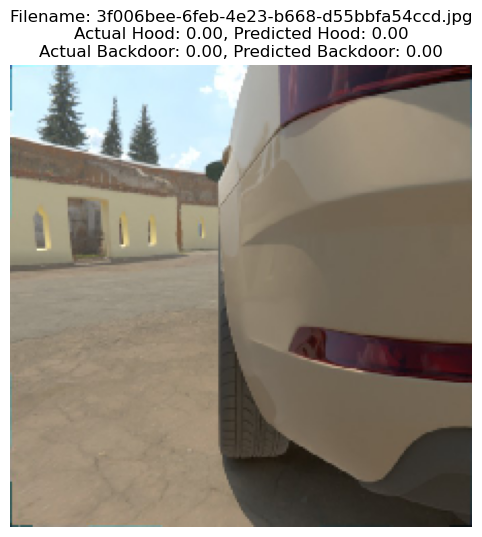

1/1 [==============================] - 0s 20ms/step


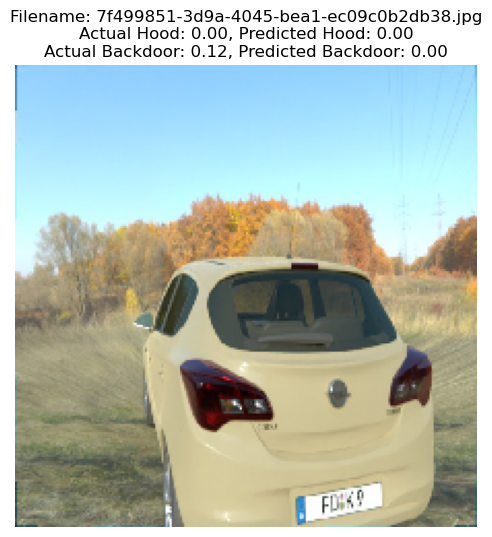

In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

def load_and_prepare_image(file_path, target_size=(224, 224)):
    """
    Load and prepare an image for prediction.

    Parameters:
    - file_path (str): The file path to the image.
    - target_size (tuple): The target size for the image.

    Returns:
    - np.array: The prepared image array.
    """
    image = load_img(file_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image /= 255.0  # Normalize to [0,1]
    return image

def display_random_predictions(model, dataframe, num_images=2, image_dir='path_to_test_images'):
    """
    Display test images with actual and predicted values.

    Parameters:
    - model: The trained Keras model.
    - dataframe (pd.DataFrame): DataFrame containing filenames and actual values.
    - num_images (int): Number of images to display.
    - image_dir (str): Directory containing test images.
    """
    # Select random images from the dataframe
    selected_indices = random.sample(list(dataframe.index), num_images)
    selected_files = dataframe.iloc[selected_indices]

    # Plot each selected image
    for index, row in selected_files.iterrows():
        file_name = row['filename']
        actual_hood = row['perspective_score_hood']
        actual_backdoor = row['perspective_score_backdoor_left']

        # Load and prepare the image
        image_path = f'{image_dir}/{file_name}'
        image = load_and_prepare_image(image_path)

        # Predict using the model
        prediction = model.predict(image)
        predicted_hood = prediction[0][0]
        predicted_backdoor = prediction[0][1]

        # Display the image
        plt.figure(figsize=(6, 6))
        plt.imshow(image[0])
        plt.axis('off')
        
        # Set the title with the filename, actual and predicted values
        plt.title(
            f'Filename: {file_name}\n'
            f'Actual Hood: {actual_hood:.2f}, Predicted Hood: {predicted_hood:.2f}\n'
            f'Actual Backdoor: {actual_backdoor:.2f}, Predicted Backdoor: {predicted_backdoor:.2f}'
        )
        plt.show()

# Load the test data CSV
test_data_path = csv_file  # Replace with the actual path to your CSV file
test_dataframe = pd.read_csv(test_data_path)

# Display random predictions
display_random_predictions(model, test_dataframe, num_images=2, image_dir=image_directory)


# Data visualization

The cells below includes visualization of the results. Scatter plot, PDF historgram and heatmaps are utilized to understand the results and the model efficiency.

In [10]:
# Actual values for hood (class 1) and backdoor left (class 2) of the test set
act_1_pred = [a[0] for a in actual]
act_2_pred = [a[1] for a in actual]

# Predicted values for hood (class 1) and backdoor left (class 2) on the test set
class_1_pred = [p[0] for p in predictions]
class_2_pred = [p[1] for p in predictions]

In [11]:
# Importing libraries for evalutation and visualization
import scipy.stats as stats
import math

def plot_gaussian_vs(ax_plt, act, pred):#, class_id):
    """
    Generates normal distribution comparing actual and predicted values.

    Parameters:
    - ax_plt (np.array): Axis, where the plot will appear.
    - act (list): Actual values.
    - pred (list): Predicted values.
    """
    title_desc = f'''Normal Distrib. Actual vs Predicted'''

    mu = sum(act)/len(act)
    sigma = math.sqrt( round(sum((xi - mu) ** 2 for xi in act) / len(act), 3) )

    mu2 = sum(pred)/len(pred)
    sigma2 = math.sqrt( round(sum((xi - mu2) ** 2 for xi in pred) / len(pred), 3) )


    width_factor = 2

    x = np.linspace(mu - width_factor*(sigma+sigma2), mu2 + width_factor*(sigma+sigma2), 100)

    ax_plt.set_title(title_desc)
    ax_plt.plot(x, stats.norm.pdf(x, mu, sigma), 'g', label = 'N(Act)')
    ax_plt.plot(x, stats.norm.pdf(x, mu2, sigma2), 'r', label = 'N(Pred)')
    ax_plt.axvline(x = mu, color = 'g', label = 'Mean - Actual')
    ax_plt.axvline(x = mu2, color = 'r', label = 'Mean - Predicted')
    ax_plt.grid()
    # ax_plt.legend()
    # ax_plt.show()

In [12]:
def plot_useless_scatter(ax_plt, act, pred, class_id, maerr):
    """
    Generates a scatter plot comparing actual and predicted values.

    Parameters:
    - ax_plt (np.array): Axis, where the plot will appear.
    - act (list): Actual values.
    - pred (list): Predicted values.
    - class_id (str): Hood or Backdoor Left.
    - maerr (float): MAE of the prediction.
    """
    title_desc = f'''Actual vs Predicted discrepency\nClass: {class_id}, MAE: {round(maerr, 3)}'''
    
    ax_plt.plot(act, 'gx', pred, 'r*')
    ax_plt.set_title(title_desc)
    # plt.legend()
    ax_plt.set_xlabel('Data Points')
    ax_plt.set_ylabel('Values')
    ax_plt.grid()
    # plt.show()

In [13]:
def plot_probability_distribution(ax_plt, act_data, pred_data, class_name, plot_color=None):
    """
    Generates a scatter plot comparing actual and predicted values.

    Parameters:
    - ax_plt (np.array): Axis, where the plot will appear.
    - act_data (list): Actual values.
    - pred_data (list): Predicted values.
    - class_name (str): Hood or Backdoor Left.
    """
    # Calculate the number of bins
    bin_size=0.05
    num_bins = int(1/bin_size)

    # Plot histogram
    n, bins, patches = ax_plt.hist(act_data, bins=num_bins, density=True, alpha=.6, color='#00FF00', edgecolor='g', range=(0,1))
    n1, bins1, patches1 = ax_plt.hist(pred_data, bins=num_bins, density=True, alpha=1, color='#000099', edgecolor='b', range=(0,1))
    
    # Plot the ceiling of the histogram
    # for patch in patches:
    #     patch.set_edgecolor('blue')
    #     patch.set_facecolor('none')

    for patch in patches1:
        patch.set_edgecolor('red')
        patch.set_facecolor('none')

    # Add title and labels
    ax_plt.set_title(f'PDF for {class_name}')
    ax_plt.set_xlabel('Value')
    ax_plt.set_ylabel('Probability Density')
    ax_plt.grid()

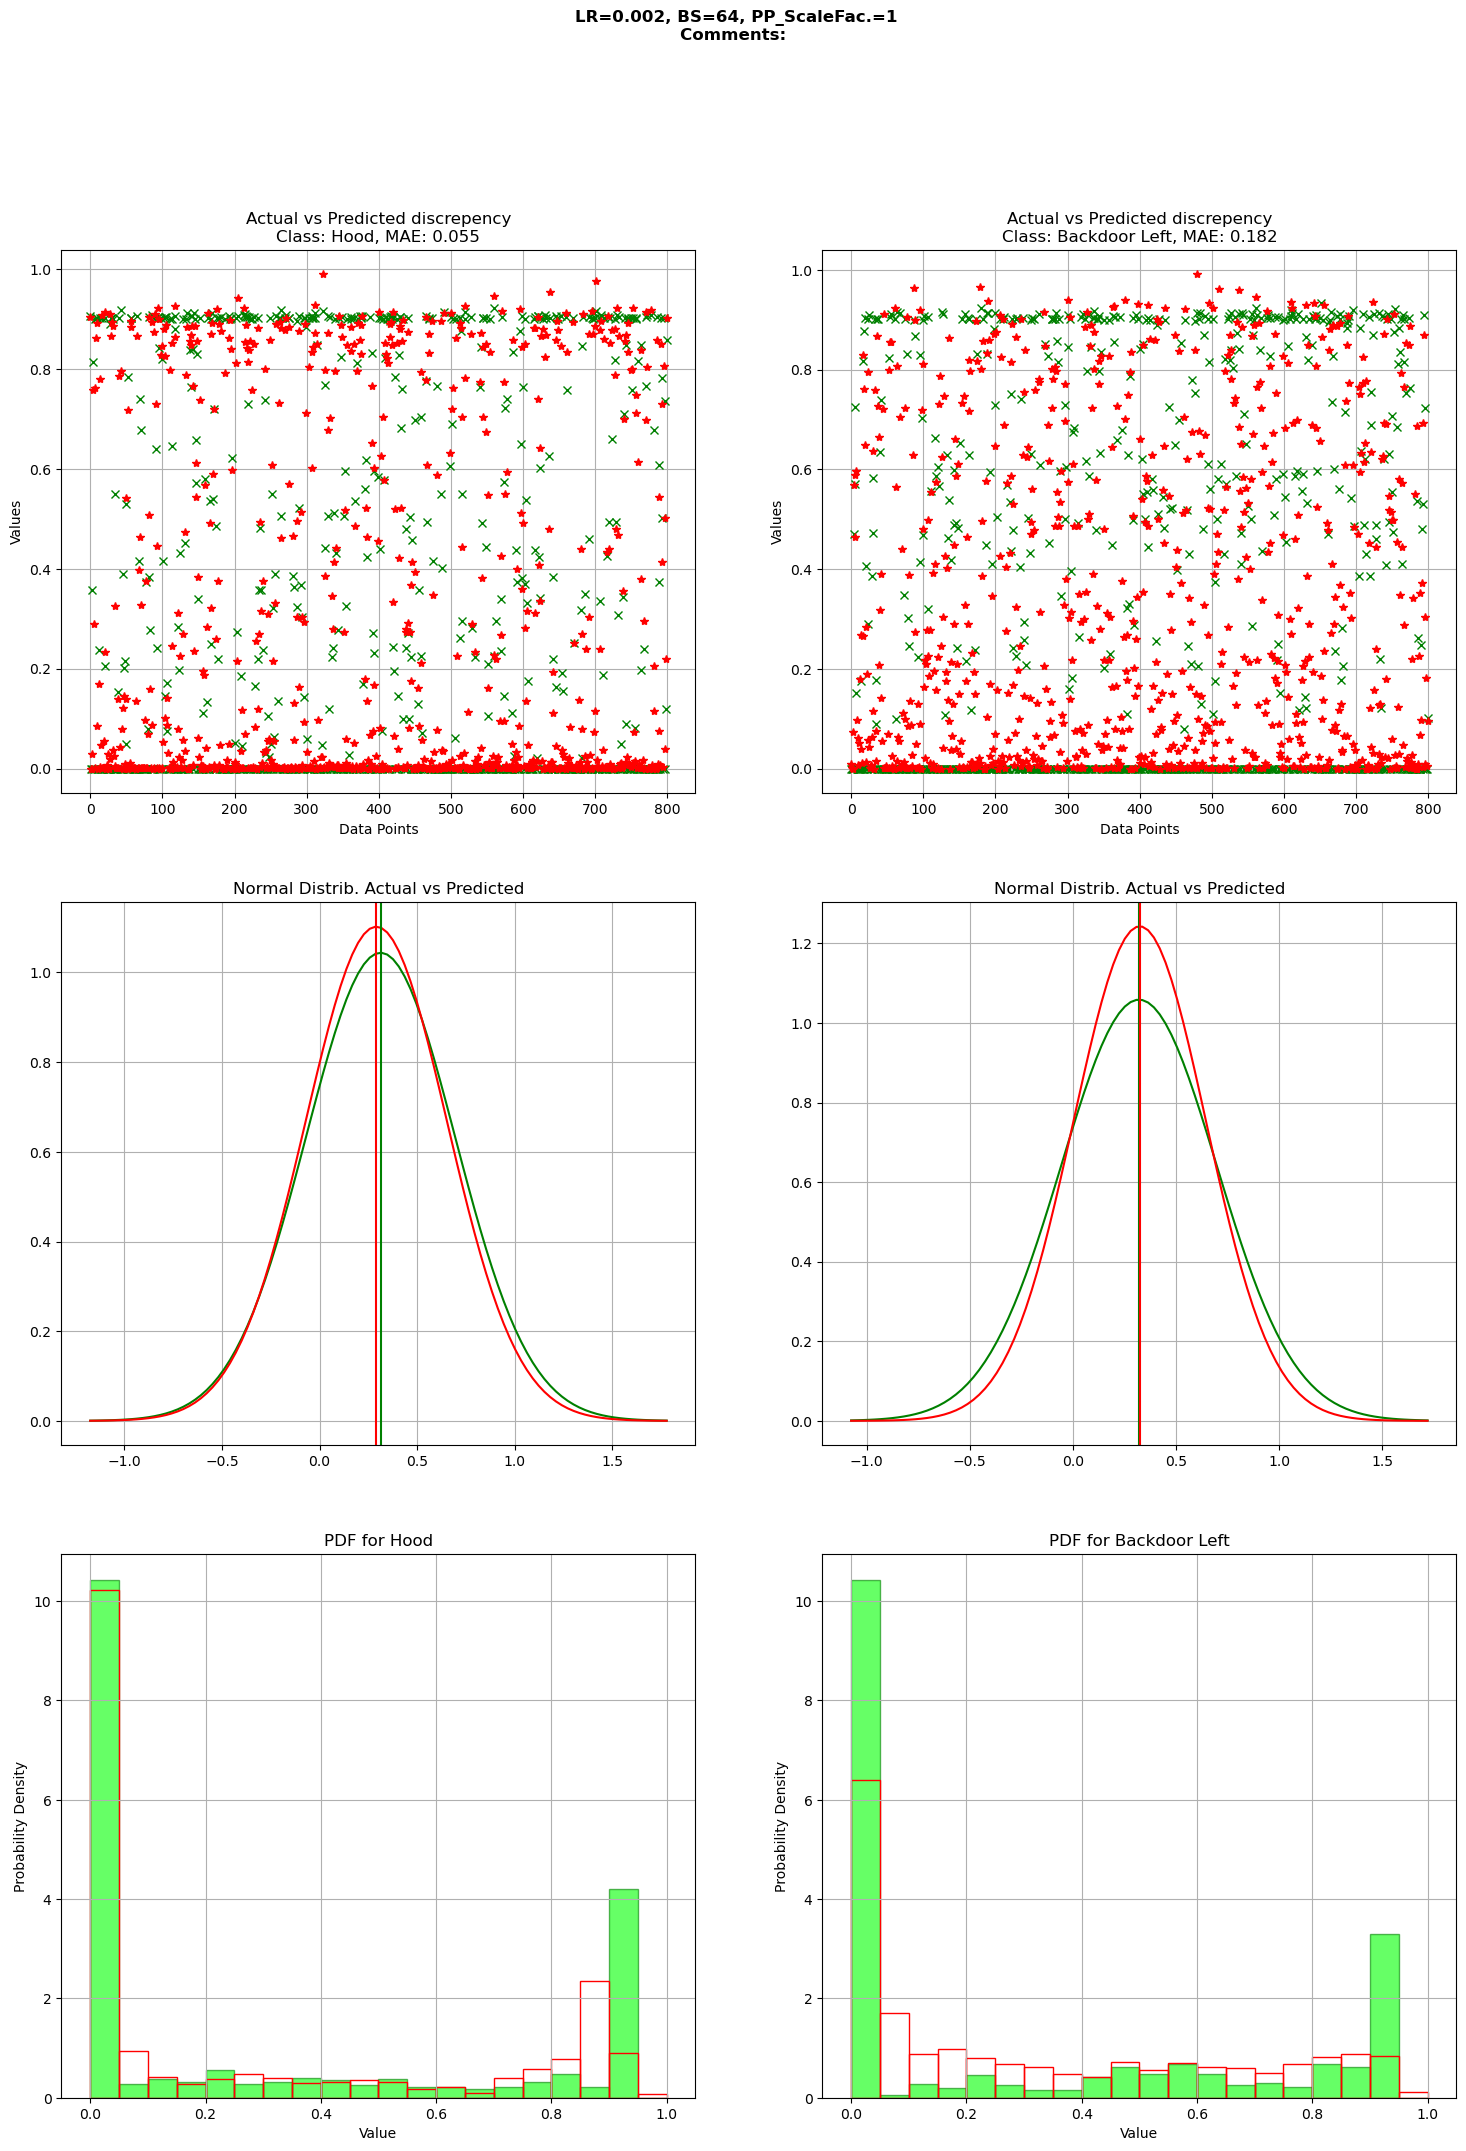

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(18, 24))

plot_useless_scatter(axs[0, 0], act_1_pred, class_1_pred, 'Hood', mae[0])
plot_useless_scatter(axs[0, 1], act_2_pred, class_2_pred, 'Backdoor Left', mae[1])

plot_gaussian_vs(axs[1,0], act_1_pred, class_1_pred)#, 'Hood')
plot_gaussian_vs(axs[1,1], act_2_pred, class_2_pred)#, 'Backdoor Left')

plot_probability_distribution(axs[2, 0], act_1_pred, class_1_pred, 'Hood')
plot_probability_distribution(axs[2, 1], act_2_pred, class_2_pred, 'Backdoor Left')

# plt.tight_layout()
notes = f''''''
title_desc = f'LR={LEARNING_RATE}, BS={BATCH_SZ}, PP_ScaleFac.={SCALE_FACTOR}'
title_desc += '\nComments: ' + notes
fig.suptitle(title_desc, fontsize=12, fontweight='bold')
plt.show()

13/13 [==============================] - 5s 392ms/step


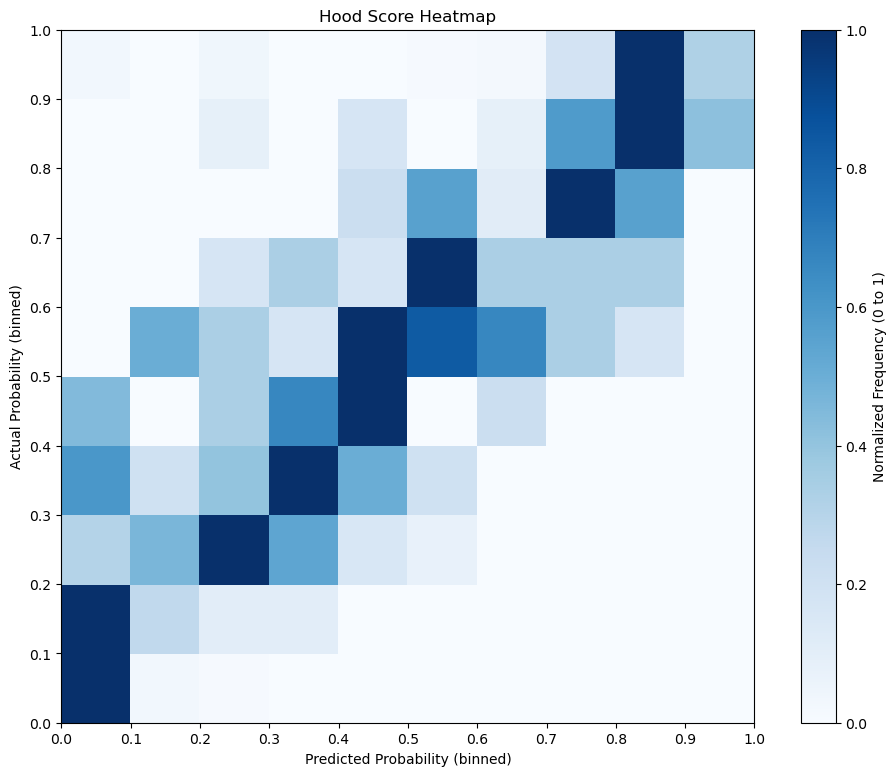

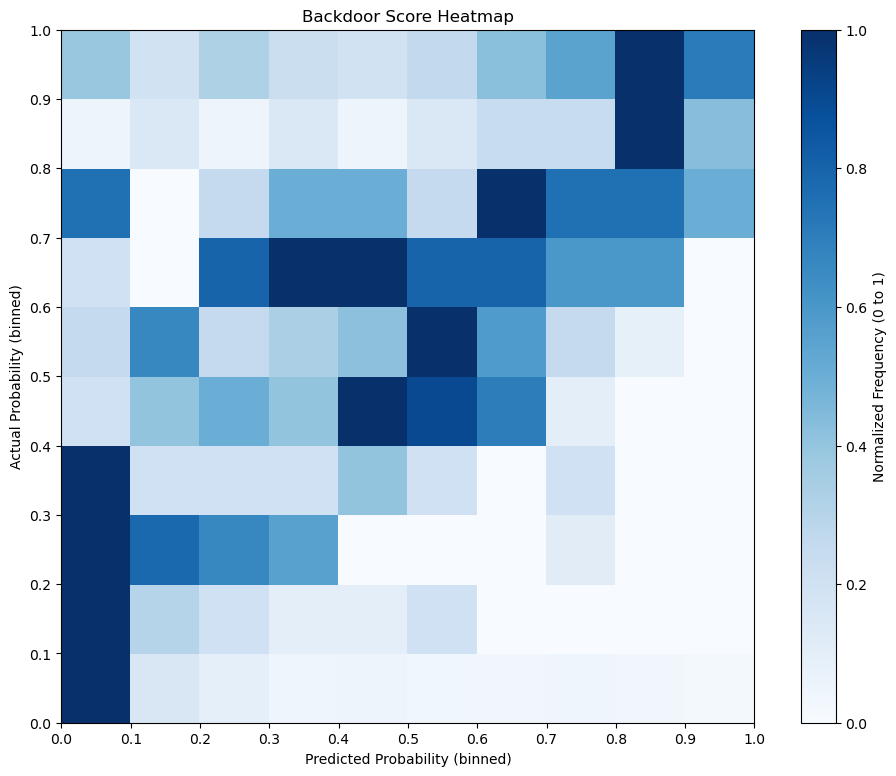

In [15]:
def generate_heatmap(actual, predicted, title):
    """
    Generate overlaid heatmaps comparing actual and predicted values.

    Parameters:
    - actual (np.array): Actual scores.
    - predicted (np.array): Predicted scores.
    - title (str): Title for the heatmap.
    """
    # Define bins for the heatmap
    bins = np.arange(0.0, 1.1, 0.1)

    # Initialize 11x11 matrices to zero for actual and predicted heatmaps
    actual_heatmap = np.zeros((len(bins) - 1, len(bins) - 1))
    # predicted_heatmap = np.zeros((len(bins) - 1, len(bins) - 1))

    # Populate the heatmaps
    for act, pred in zip(actual, predicted):
        # Find bin index for actual and predicted values
        act_idx = np.digitize(act, bins) - 1
        pred_idx = np.digitize(pred, bins) - 1
        
        # Increment the corresponding cells in the heatmaps
        actual_heatmap[act_idx,pred_idx] += 1
        # predicted_heatmap[pred_idx,act_idx] += 1

    # Normalize the heatmaps to maximum frequency of 1
    for i in range(len(bins)-1):
        actual_heatmap[i,:] /= np.max(actual_heatmap[i])
        # predicted_heatmap[:,i] /= np.max(predicted_heatmap[:,i])

    # Plot the heatmaps
    plt.figure(figsize=(12, 9))

    # Plot actual heatmap (Red)
    plt.imshow(
        actual_heatmap,
        cmap='Blues',
        alpha=1.0,
        interpolation='nearest',
        origin='lower',
        extent=[0, 1, 0, 1],
    )

    # # Plot predicted heatmap (Yellow)
    # plt.imshow(
    #     predicted_heatmap,
    #     cmap='BuPu',
    #     alpha=0.2,
    #     interpolation='nearest',
    #     origin='lower',
    #     extent=[0, 1, 0, 1],
    # )

    plt.colorbar(label='Normalized Frequency (0 to 1)')
    plt.title(title)
    plt.xlabel('Predicted Probability (binned)')
    plt.ylabel('Actual Probability (binned)')
    plt.xticks(bins)
    plt.yticks(bins)
    plt.grid(False)
    plt.show()

# Predict on the test data
test_predictions = model.predict(test_generator)

# Assuming test_generator has the true labels in its .labels attribute
actual_scores = test_generator.labels

# Extract actual and predicted values for hood and backdoor
actual_hood = actual_scores[:, 0]
predicted_hood = test_predictions[:, 0]

actual_backdoor = actual_scores[:, 1]
predicted_backdoor = test_predictions[:, 1]

# Generate heatmaps
generate_heatmap(actual_hood, predicted_hood, 'Hood Score Heatmap')
generate_heatmap(actual_backdoor, predicted_backdoor, 'Backdoor Score Heatmap')

# Model inference

The model is saved for predicting results on unseen data. The saved model can be loaded and used for inference.

In [16]:
# Save the trained model
model.save('car_hood_backdoor_detector.keras')

In [17]:
# Inference using the trained model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """
    Load an image and preprocess it for prediction with a trained model.
    
    Parameters:
    - img_path (str): The path to the image file.
    - target_size (tuple): The target size to resize the image.
    
    Returns:
    - preprocessed_img (numpy array): The preprocessed image.
    """
    # Load the image from the path
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert the image to an array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to match the input shape of the model
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image for MobileNetV3Small (scaling pixel values)
    preprocessed_img = preprocess_input(img_array)
    
    return preprocessed_img

def predict_car_components(img_path, model_path='path_to_saved_model.h5'):
    """
    Predict the probability scores for car components in an image using a trained model.
    
    Parameters:
    - img_path (str): The path to the image file to be predicted.
    - model_path (str): The path to the saved model file.
    
    Returns:
    - predictions (tuple): The probability scores for the hood and left backdoor.
    """
    # Load the trained model
    model = load_model(model_path)
    
    # Load and preprocess the image
    preprocessed_img = load_and_preprocess_image(img_path)
    
    # Make predictions
    prediction = model.predict(preprocessed_img)
    
    # Extract probabilities
    hood_probability = prediction[0][0]
    backdoor_probability = prediction[0][1]
    
    return hood_probability, backdoor_probability

# Inference
img_path = 'test_1.jpg'
model_path = 'car_hood_backdoor_detector.keras'

hood_prob, backdoor_prob = predict_car_components(img_path, model_path)
print(f"Probability that the hood is visible: {hood_prob:.2f}")
print(f"Probability that the left backdoor is visible: {backdoor_prob:.2f}")

1/1 [==============================] - 1s 570ms/step
Probability that the hood is visible: 0.80
Probability that the left backdoor is visible: 0.17
